# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

### Introducción al proyecto

- Al igual que cualquier proyecto de análisis, es de vital importancia contar con un orden e ir poco a poco construyendo el código. Primero habrá que cargar las librerías y los datos correspondientes.
- Una vez completado el primer paso, valdría la pena revisar cada dataframe con los métodos info y head, para conocer de qué trata cada conjunto de datos y localizar errores.
- Ya encontrados los errores evidentes, se deberán corregir y limpiar los datos durante la etapa de preprocesamiento.
- Cuando tengamos los dataframes listos y sin errores, podremos sumergirnos en manipular los datos para crear visualizaciones, hipótesis y conclusiones.

## Inicialización

In [2144]:
# Cargar todas las librerías

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as st
import math


## Cargar datos

In [2145]:
# Carga los archivos de datos en diferentes DataFrames

df_calls = pd.read_csv('megaline_calls.csv')
df_internet = pd.read_csv('megaline_internet.csv')
df_messages = pd.read_csv('megaline_messages.csv')
df_plans = pd.read_csv('megaline_plans.csv')
df_users = pd.read_csv('megaline_users.csv')


## Preparar los datos

## Tarifas

In [2146]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas

df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [2147]:
# Imprime una muestra de los datos para las tarifas

df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Al intentar pedir el método sample en el dataframe de las tarifas, me arrojó un error indicando que existían menos registros que 10, por ello opté por mejor imprimir un head y me llevé la sorpresa de que este dataframe únicamente contiene datos de los 2 planes ofertados por la empresa: Surf y Ultimate.

Ahora mismo lo que se me podría ocurrir de error únicamente, es la granularidad de los datos, ya que estaríamos manejando tanto GB como MB en una misma tabla. Esto podría dar problemas si planeamos en el futuro realizar operaciones aritméticas al momento de calcular los excedentes que tuvo cada usuario de sus datos para internet. Afortunadamente con una simple multiplicación o división podemos corregir esta diferencia de granularidad.

Fuera de esto, los datos parecen estar en sus datatypes correctos y sin valores ausentes.

### Corregir datos

In [2148]:
# Convertir la columna de usd_per_gb a MBs y crear una nueva columna

df_plans['usd_per_mb'] = df_plans['usd_per_gb']/1024

df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,usd_per_mb
0,50,15360,500,20,10,0.03,0.03,surf,0.009766
1,1000,30720,3000,70,7,0.01,0.01,ultimate,0.006836


### Enriquecer los datos

In [2149]:
# Generar una columna donde podamos ver los GBs por mes, solamente por si acaso.

df_plans['gb_per_month_included'] = df_plans['mb_per_month_included']/1024

df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,usd_per_mb,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,0.009766,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,0.006836,30.0


## Usuarios/as

In [2150]:
# Imprime la información general/resumida sobre el DataFrame de usuarios

df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [2151]:
# Imprime una muestra de datos para usuarios

df_users.sample(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
49,1049,Loise,Avery,25,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-21,surf,NaN
411,1411,Man,Fleming,64,"Rochester, NY MSA",2018-08-10,surf,NaN
190,1190,Troy,Hutchinson,56,"Virginia Beach-Norfolk-Newport News, VA-NC MSA",2018-08-01,ultimate,NaN
273,1273,Hermila,Ryan,25,"Baton Rouge, LA MSA",2018-10-13,ultimate,NaN
11,1011,Halina,Henry,73,"Cleveland-Elyria, OH MSA",2018-01-18,ultimate,NaN
178,1178,Charlsie,Reid,53,"Cincinnati, OH-KY-IN MSA",2018-10-05,surf,NaN
205,1205,Rafael,Wade,43,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-05,surf,NaN
131,1131,Shane,Morrison,60,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-01-07,surf,NaN
162,1162,Mark,Farley,20,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-07-12,ultimate,NaN
351,1351,Kyle,Grimes,47,"San Antonio-New Braunfels, TX MSA",2018-09-05,ultimate,NaN


Lo primero que salta a la vista es que contamos con columnas que tienen información de fecha y están con datatype de object, claramente podríamos pasarlos a datetime y además, crear nuevas columnas donde se extraiga el mes, el año e incluso el día si es necesario. Esto con el fin de crear agrupaciones posteriores al momento de generar gráficos que muestren cambios a lo largo del año.

Los datatype nulos de churn_date no hace falta alterarlos, ya que estos significan simplemente que los planes seguían activos (contratados) por los usuarios al momento de extraer estos datos.

Algo que podría llegar a complicar el análisis, dependiendo de lo que se decida hacer, es la columna de city estando con valores tan largos, con guiones y con nombres que podrían tener errores. Habrá que continuar con el ejercicio para determinar si hace falta realizarles alguna modificación.

Igual buscaría duplicados explícitos.

### Corregir los datos

In [2152]:
# Convertir las columnas reg_date y churn_date a datatype de datetime

df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')

df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')

df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [2153]:
# Buscar duplicados

df_users.duplicated().sum()

np.int64(0)

### Enriquecer los datos

In [2154]:
# Agregar columnas de año, mes y día para el año de registro, no lo haremos con churn_date por el momento, ya que no parece ser necesario

df_users['year'] = df_users['reg_date'].dt.year
df_users['month'] = df_users['reg_date'].dt.month
df_users['day'] = df_users['reg_date'].dt.day

df_users.sample(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,year,month,day
25,1025,Jess,Wilkinson,64,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-10-28,ultimate,NaT,2018,10,28
118,1118,Deane,Ramirez,28,"Columbus, OH MSA",2018-12-08,surf,NaT,2018,12,8
101,1101,Sage,Conley,27,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-02-08,surf,NaT,2018,2,8
326,1326,Johnathon,Branch,21,"Greensboro-High Point, NC MSA",2018-02-06,surf,NaT,2018,2,6
435,1435,Darnell,Powell,23,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-07-24,ultimate,NaT,2018,7,24
264,1264,Jessie,Hill,69,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-05-03,ultimate,NaT,2018,5,3
460,1460,Winford,Underwood,46,"Fresno, CA MSA",2018-05-28,ultimate,NaT,2018,5,28
409,1409,Elvis,Vargas,38,"Charlotte-Concord-Gastonia, NC-SC MSA",2018-10-04,ultimate,NaT,2018,10,4
74,1074,Particia,Fuller,69,"Knoxville, TN MSA",2018-11-26,ultimate,NaT,2018,11,26
95,1095,Lilliam,Alvarado,55,"Louisville/Jefferson County, KY-IN MSA",2018-04-21,surf,NaT,2018,4,21


## Llamadas

In [2155]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas

df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [2156]:
# Imprime una muestra de datos para las llamadas

df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


Encontramos una columna de call_date, la cual estaría mejor que estuviera en datatype de datetime. Posterior a esto, tendríamos que crear columnas individuales para representar el año, el mes y el día.

Separaré la columna de id para que quede el id único de llamada en una columna individual.

Así mismo, debemos redondear al valor superior la duración de las llamadas para que concuerde con lo que Megaline ofrece. Junto con ello, crearemos la columna con datatype de int.


Como de costumbre, buscaré duplicados.

### Corregir los datos

In [2157]:
# Convertir la columna call_date a datatype datetime

df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format="%Y-%m-%d")

df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [2158]:
# Redondear los minutos de las llamadas al valor superior, por protocolo de Megaline

df_calls['real_duration_min'] = df_calls['duration'].apply(math.ceil)

df_calls.head()

,id,user_id,call_date,duration,real_duration_min
0,1000_93,1000,2018-12-27,8.52,9
1,1000_145,1000,2018-12-27,13.66,14
2,1000_247,1000,2018-12-27,14.48,15
3,1000_309,1000,2018-12-28,5.76,6
4,1000_380,1000,2018-12-30,4.22,5


In [2159]:
df_calls.duplicated().sum()

np.int64(0)

### Enriquecer los datos

In [2160]:
# Crear columnas individuales para el año, el mes y el día.

df_calls['year'] = df_calls['call_date'].dt.year
df_calls['month'] = df_calls['call_date'].dt.month
df_calls['day'] = df_calls['call_date'].dt.day

df_calls.sample(10)

,id,user_id,call_date,duration,real_duration_min,year,month,day
9493,1042_426,1042,2018-11-14,3.78,4,2018,11,14
50609,1182_218,1182,2018-10-24,7.53,8,2018,10,24
19206,1073_10,1073,2018-07-02,4.11,5,2018,7,2
8441,1039_381,1039,2018-10-13,1.10,2,2018,10,13
76618,1273_202,1273,2018-12-17,15.56,16,2018,12,17
25393,1098_60,1098,2018-09-09,1.43,2,2018,9,9
137238,1498_166,1498,2018-04-12,0.00,0,2018,4,12
108611,1383_296,1383,2018-12-16,16.76,17,2018,12,16
25103,1097_206,1097,2018-08-26,7.06,8,2018,8,26
93160,1334_528,1334,2018-09-28,4.63,5,2018,9,28


## Mensajes

In [2161]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes

df_messages.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [2162]:
# Imprime una muestra de datos para los mensajes

df_messages.sample(10)

,id,user_id,message_date
6221,1055_339,1055,2018-08-21
59038,1374_212,1374,2018-11-25
15253,1101_310,1101,2018-08-26
53509,1340_35,1340,2018-12-25
55282,1347_319,1347,2018-08-26
25312,1151_155,1151,2018-11-22
63036,1399_101,1399,2018-10-21
28442,1174_232,1174,2018-05-24
20293,1128_262,1128,2018-07-16
25778,1155_149,1155,2018-07-14


Me doy cuenta que hay un par de datatypes que me gustaría cambiar, ya que contamos con un dato de fecha y se podría hacer fácilmente datatype datetime, además, podría crear nuevamente nuevas columnas donde se almacene la información únicamente del año, de mes y del día individualmente, para fines de agrupación posteriores.

Además, la columna del id siento que no ayuda mucho que el formato sea user_id + _ + id de llamada, entonces me gustaría quitar el prefijo que contiene el user_id y el guión bajo. Lo haré en una columna nueva para evitar alterar los datos originales.

Por último, buscaría duplicados explícitos.

### Corregir los datos

In [2163]:
# Cambiar el datatype de message_date

df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format="%Y-%m-%d")

df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


In [2164]:
# Buscar duplicados

df_messages.duplicated().sum()

np.int64(0)

### Enriquecer los datos

In [2165]:
# Agregar columnas individuales para año, mes y día

df_messages['year'] = df_messages['message_date'].dt.year
df_messages['month'] = df_messages['message_date'].dt.month
df_messages['day'] = df_messages['message_date'].dt.day

df_messages.head()


,id,user_id,message_date,year,month,day
0,1000_125,1000,2018-12-27,2018,12,27
1,1000_160,1000,2018-12-31,2018,12,31
2,1000_223,1000,2018-12-31,2018,12,31
3,1000_251,1000,2018-12-27,2018,12,27
4,1000_255,1000,2018-12-26,2018,12,26


In [2166]:
# Crear una nueva columna con el id único de llamada

df_messages['message_id'] = df_messages['id'].str.split('_').str[1]
df_messages.head()

,id,user_id,message_date,year,month,day,message_id
0,1000_125,1000,2018-12-27,2018,12,27,125
1,1000_160,1000,2018-12-31,2018,12,31,160
2,1000_223,1000,2018-12-31,2018,12,31,223
3,1000_251,1000,2018-12-27,2018,12,27,251
4,1000_255,1000,2018-12-26,2018,12,26,255


In [2167]:
# Convertir la columna de call_id a tipo entero

df_messages['message_id'] = df_messages['message_id'].astype('int64')

df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   year          76051 non-null  int32         
 4   month         76051 non-null  int32         
 5   day           76051 non-null  int32         
 6   message_id    76051 non-null  int64         
dtypes: datetime64[ns](1), int32(3), int64(2), object(1)
memory usage: 3.2+ MB


## Internet

In [2168]:
# Imprime la información general/resumida sobre el DataFrame de internet

df_internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [2169]:
# Imprime una muestra de datos para el tráfico de internet

df_internet.sample(10)

,id,user_id,session_date,mb_used
15927,1072_239,1072,2018-09-07,220.03
58425,1263_229,1263,2018-09-13,159.09
67217,1312_440,1312,2018-06-21,837.09
81507,1382_40,1382,2018-08-14,660.22
34368,1155_429,1155,2018-10-06,787.59
66916,1312_139,1312,2018-11-22,0.00
85981,1400_112,1400,2018-12-21,255.06
103242,1494_124,1494,2018-12-30,164.75
5917,1032_78,1032,2018-12-03,86.36
2956,1016_220,1016,2018-11-08,99.19


Aquí observo que la columna de session_date está en datatype object, y me gustaría que fuera en datetime. Al igual que en los ejercicios anteriores, crearía columnas nuevas con los datos de año, mes y día.
Similar a lo anterior, crearé una nueva columna con el id único de sesión, solamente por si llegase a ser funcional después. Esta columna la tendré en tipo int.

Por último, buscaré duplicados.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [2170]:
# Convertir columna session_date a datetime 

df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [2171]:
# Buscar duplicados

df_internet.duplicated().sum()

np.int64(0)

### Enriquecer los datos

In [2172]:
# Agregar columnas de año, mes y día de cada sesión

df_internet['year'] = df_internet['session_date'].dt.year
df_internet['month'] = df_internet['session_date'].dt.month
df_internet['day'] = df_internet['session_date'].dt.day

df_internet.sample(10)

,id,user_id,session_date,mb_used,year,month,day
30450,1139_337,1139,2018-12-27,771.28,2018,12,27
67723,1314_61,1314,2018-11-04,496.13,2018,11,4
67907,1316_154,1316,2018-11-12,601.83,2018,11,12
69530,1324_248,1324,2018-06-29,737.92,2018,6,29
71397,1333_115,1333,2018-12-18,287.91,2018,12,18
17670,1080_1,1080,2018-10-01,1139.81,2018,10,1
70302,1328_261,1328,2018-05-20,653.70,2018,5,20
52422,1236_280,1236,2018-10-04,136.05,2018,10,4
32717,1147_351,1147,2018-10-24,793.56,2018,10,24
33889,1154_49,1154,2018-11-13,212.87,2018,11,13


In [2173]:
# Extraer el id único de sesión y ponerlo en una nueva columna

df_internet['session_id'] = df_internet['id'].str.split('_').str[1]

df_internet.head()

,id,user_id,session_date,mb_used,year,month,day,session_id
0,1000_13,1000,2018-12-29,89.86,2018,12,29,13
1,1000_204,1000,2018-12-31,0.00,2018,12,31,204
2,1000_379,1000,2018-12-28,660.40,2018,12,28,379
3,1000_413,1000,2018-12-26,270.99,2018,12,26,413
4,1000_442,1000,2018-12-27,880.22,2018,12,27,442


## Estudiar las condiciones de las tarifas

In [2174]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras

df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,usd_per_mb,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,0.009766,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,0.006836,30.0


## Agregar datos por usuario

In [2175]:
# Imprimir una porción del dataframe de llamadas para ubicarnos

df_calls.head()

,id,user_id,call_date,duration,real_duration_min,year,month,day
0,1000_93,1000,2018-12-27,8.52,9,2018,12,27
1,1000_145,1000,2018-12-27,13.66,14,2018,12,27
2,1000_247,1000,2018-12-27,14.48,15,2018,12,27
3,1000_309,1000,2018-12-28,5.76,6,2018,12,28
4,1000_380,1000,2018-12-30,4.22,5,2018,12,30


In [2176]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.

monthly_calls_per_user = df_calls.groupby(['user_id', 'month']).size().reset_index(name='num_calls')

monthly_calls_per_user

,user_id,month,num_calls
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


In [2177]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.

monthly_min_per_user = df_calls.groupby(['user_id','month']).agg({'real_duration_min': 'sum'})

monthly_min_per_user

real_duration_min
user_id month                   
1000    12                   124
1001    8                    182
        9                    315
        10                   393
        11                   426
...                          ...
1498    12                   339
1499    9                    346
        10                   385
        11                   308
        12                   496

[2258 rows x 1 columns]

In [2178]:
# Reimprimir información del dataframe de mensajes para recordar los datos

df_messages.head()

,id,user_id,message_date,year,month,day,message_id
0,1000_125,1000,2018-12-27,2018,12,27,125
1,1000_160,1000,2018-12-31,2018,12,31,160
2,1000_223,1000,2018-12-31,2018,12,31,223
3,1000_251,1000,2018-12-27,2018,12,27,251
4,1000_255,1000,2018-12-26,2018,12,26,255


In [2179]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.

monthly_msgs_per_user = df_messages.groupby(['user_id', 'month']).size().reset_index(name='msgs_count')

monthly_msgs_per_user

,user_id,month,msgs_count
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [2180]:
# Reimprimir el dataframe de internet para recordar los datos

df_internet.head(10)


,id,user_id,session_date,mb_used,year,month,day,session_id
0,1000_13,1000,2018-12-29,89.86,2018,12,29,13
1,1000_204,1000,2018-12-31,0.00,2018,12,31,204
2,1000_379,1000,2018-12-28,660.40,2018,12,28,379
3,1000_413,1000,2018-12-26,270.99,2018,12,26,413
4,1000_442,1000,2018-12-27,880.22,2018,12,27,442
5,1001_0,1001,2018-08-24,284.68,2018,8,24,0
6,1001_3,1001,2018-12-09,656.04,2018,12,9,3
7,1001_4,1001,2018-11-04,16.97,2018,11,4,4
8,1001_10,1001,2018-11-27,135.18,2018,11,27,10
9,1001_15,1001,2018-12-13,761.92,2018,12,13,15


In [2181]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.

monthly_internet_per_user = df_internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'})

monthly_internet_per_user

mb_used
user_id month          
1000    12      1901.47
1001    8       6919.15
        9      13314.82
        10     22330.49
        11     18504.30
...                 ...
1498    12     23137.69
1499    9      12984.76
        10     19492.43
        11     16813.83
        12     22059.21

[2277 rows x 1 columns]

In [2182]:
# Redondear los mb para tener el valor real cobrado por parte de Megaline

monthly_internet_per_user['mb_used'] = (monthly_internet_per_user['mb_used']/1024).apply(math.ceil)*1024

monthly_internet_per_user

mb_used
user_id month         
1000    12        2048
1001    8         7168
        9        14336
        10       22528
        11       19456
...                ...
1498    12       23552
1499    9        13312
        10       20480
        11       17408
        12       22528

[2277 rows x 1 columns]

In [2183]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month

df_user_combined = monthly_calls_per_user.merge(monthly_min_per_user, on=['user_id', 'month']).merge(monthly_msgs_per_user, on=['user_id', 'month']).merge(monthly_internet_per_user, on=['user_id','month'])

df_user_combined

,user_id,month,num_calls,real_duration_min,msgs_count,mb_used
0,1000,12,16,124,11,2048
1,1001,8,27,182,30,7168
2,1001,9,49,315,44,14336
3,1001,10,65,393,53,22528
4,1001,11,64,426,36,19456
...,...,...,...,...,...,...
1754,1496,9,52,414,21,17408
1755,1496,10,46,317,18,14336
1756,1496,11,39,308,13,9216
1757,1496,12,40,294,11,17408


In [2184]:
# Recordar la información de las tarifas

df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,usd_per_mb,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,0.009766,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,0.006836,30.0


In [2185]:
# Recordar la información de los usuarios

df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,year,month,day
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,2018,12,24
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,2018,8,13
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,2018,10,21
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT,2018,1,28
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT,2018,5,23


In [2186]:
# Extraer cada información de plan por usuario

df_user_plan = df_users[['user_id', 'plan']]

df_user_plan

,user_id,plan
0,1000,ultimate
1,1001,surf
2,1002,surf
3,1003,surf
4,1004,surf
...,...,...
495,1495,surf
496,1496,surf
497,1497,ultimate
498,1498,surf


In [2187]:
# Añade la información de la tarifa

df_user_combined = df_user_combined.merge(df_user_plan, on='user_id')

df_user_combined

,user_id,month,num_calls,real_duration_min,msgs_count,mb_used,plan
0,1000,12,16,124,11,2048,ultimate
1,1001,8,27,182,30,7168,surf
2,1001,9,49,315,44,14336,surf
3,1001,10,65,393,53,22528,surf
4,1001,11,64,426,36,19456,surf
...,...,...,...,...,...,...,...
1754,1496,9,52,414,21,17408,surf
1755,1496,10,46,317,18,14336,surf
1756,1496,11,39,308,13,9216,surf
1757,1496,12,40,294,11,17408,surf


[Calcula los ingresos mensuales por usuario (resta el límite del paquete gratuito del número total de llamadas, mensajes de texto y datos; multiplica el resultado por el valor del plan de llamadas; añade la tarifa mensual en función del plan de llamadas). Nota: Dadas las condiciones del plan, ¡esto podría no ser tan trivial como un par de líneas! Así que no pasa nada si dedicas algo de tiempo a ello.]

In [2188]:
# Calcula el ingreso mensual para cada usuario

def income_calc(row):

    # Calcular todo para los planes surf
    if row['plan'] == 'surf':

        # Cálculo de minutos en llamadas

        min_month_extra = row['real_duration_min'] - 500
        if min_month_extra > 0:
            call_cost_extra = min_month_extra * 0.03
        else:
            call_cost_extra = 0

        # Cálculo de mensajes

        msgs_month_extra = row['msgs_count'] - 50
        if msgs_month_extra > 0:
            msgs_cost_extra = msgs_month_extra * 0.03
        else:
            msgs_cost_extra = 0

        # Cálculo de megabytes

        mb_month_extra = row['mb_used'] - (15*1024)
        if mb_month_extra > 0:
            mb_cost_extra = mb_month_extra/1024
            mb_cost_extra = math.ceil(mb_cost_extra)
            mb_cost_extra *= 10
        else:
            mb_cost_extra = 0

        # Sumar tarifa normal

        income = 20 + call_cost_extra + msgs_cost_extra + mb_cost_extra

        return income
    
    # Calcular todo para los planes ultimate
    else:

        # Cálculo de minutos en llamadas
        
        min_month_extra = row['real_duration_min'] - 3000
        if min_month_extra > 0:
            call_cost_extra = min_month_extra * 0.01
        else:
            call_cost_extra = 0

        # Cálculo de mensajes

        msgs_month_extra = row['msgs_count'] - 1000
        if msgs_month_extra > 0:
            msgs_cost_extra = msgs_month_extra * 0.01
        else:
            msgs_cost_extra = 0

        # Cálculo de megabytes

        mb_month_extra = row['mb_used'] - (30*1024)
        if mb_month_extra > 0:
            mb_cost_extra = mb_month_extra/1024
            mb_cost_extra = math.ceil(mb_cost_extra)
            mb_cost_extra *= 7
        else:
            mb_cost_extra = 0

        # Sumar tarifa normal

        income = 70 + call_cost_extra + msgs_cost_extra + mb_cost_extra

        return income
    
df_user_combined['income'] = df_user_combined.apply(income_calc, axis=1)

df_user_combined

,user_id,month,num_calls,real_duration_min,msgs_count,mb_used,plan,income
0,1000,12,16,124,11,2048,ultimate,70.00
1,1001,8,27,182,30,7168,surf,20.00
2,1001,9,49,315,44,14336,surf,20.00
3,1001,10,65,393,53,22528,surf,90.09
4,1001,11,64,426,36,19456,surf,60.00
...,...,...,...,...,...,...,...,...
1754,1496,9,52,414,21,17408,surf,40.00
1755,1496,10,46,317,18,14336,surf,20.00
1756,1496,11,39,308,13,9216,surf,20.00
1757,1496,12,40,294,11,17408,surf,40.00


## Estudia el comportamiento de usuario

[Calcula algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibuja gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar las tarifas y decidir cuál es más rentable, las estadísticas y gráficas deben calcularse por tarifa.]

[En los comentarios hallarás pistas relevantes para las llamadas, pero no las hay para los mensajes e Internet. Sin embargo, el principio del estudio estadístico que se aplica para ellos es el mismo que para las llamadas.]

### Llamadas

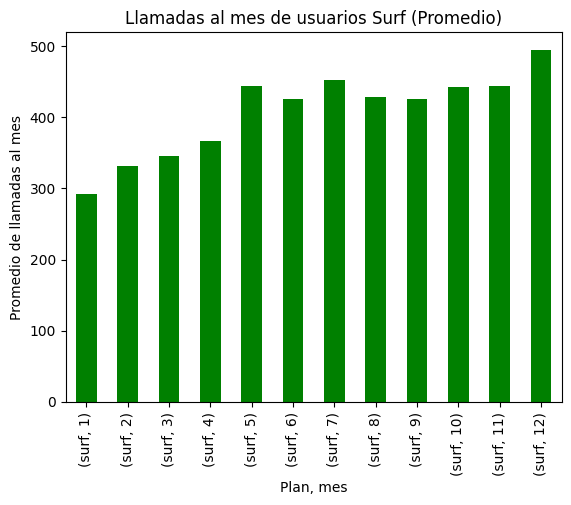

In [2189]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

# Gráfico para el plan surf

df_user_combined_surf = df_user_combined.query('plan == "surf"')

df_user_combined_surf.groupby(by=['plan','month']).agg({'real_duration_min' : 'mean'}).plot(kind='bar', xlabel='Plan, mes', ylabel='Promedio de llamadas al mes', legend=False, color='green', title='Llamadas al mes de usuarios Surf (Promedio)')

plt.show()

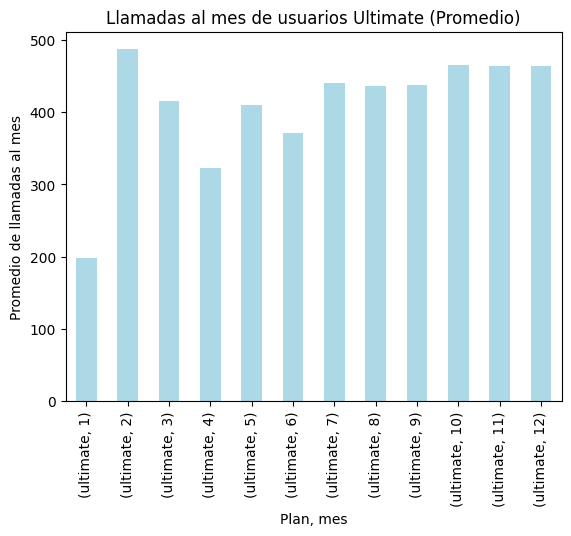

In [2190]:
# Gráfico para el plan ultimate

df_user_combined_ultimate = df_user_combined.query('plan == "ultimate"')

df_user_combined_ultimate.groupby(by=['plan','month']).agg({'real_duration_min' : 'mean'}).plot(kind='bar', xlabel='Plan, mes', ylabel='Promedio de llamadas al mes', legend=False, color='lightblue', title='Llamadas al mes de usuarios Ultimate (Promedio)')

plt.show()

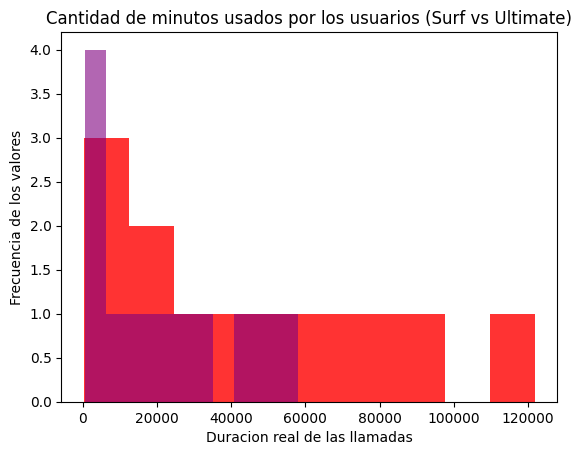

In [2191]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

min_data_surf = df_user_combined_surf.groupby(by=['plan','month']).agg({'real_duration_min' : 'sum'}) # Primeros datos para el histograma, del plan surf
min_data_ultimate = df_user_combined_ultimate.groupby(by=['plan','month']).agg({'real_duration_min' : 'sum'}) # Segundos datos para el histograma, del plan ultimate

plt.hist(min_data_surf, alpha=0.8, color='red')
plt.hist(min_data_ultimate, alpha=0.6, color='purple')
plt.xlabel('Duracion real de las llamadas')
plt.ylabel('Frecuencia de los valores')
plt.title('Cantidad de minutos usados por los usuarios (Surf vs Ultimate)')

plt.show()


[Calcula la media y la variable de la duración de las llamadas para averiguar si los usuarios de los distintos planes se comportan de forma diferente al realizar sus llamadas.]

In [2192]:
min_data_surf.describe()

,real_duration_min
count,12.000000
mean,43834.583333
std,39684.590885
min,292.000000
25%,10993.250000
50%,35011.500000
75%,66985.000000
max,121787.000000


In [2193]:
# Calcula la media y la varianza de la duración mensual de llamadas. # SURF

avg_call_time_surf = min_data_surf.mean()
var_call_time_surf = min_data_surf.var()

avg_call_time_surf

real_duration_min    43834.583333
dtype: float64

In [2194]:
min_data_ultimate.describe()

,real_duration_min
count,12.000000
mean,21351.250000
std,19338.218307
min,593.000000
25%,4599.750000
50%,17193.500000
75%,33532.500000
max,57912.000000


In [2195]:
# Calcula la media y la varianza de la duración mensual de llamadas. # ULTIMATE

avg_call_time_ultimate = min_data_ultimate.mean()
var_call_time_ultimate = min_data_ultimate.var()

avg_call_time_ultimate


real_duration_min    21351.25
dtype: float64

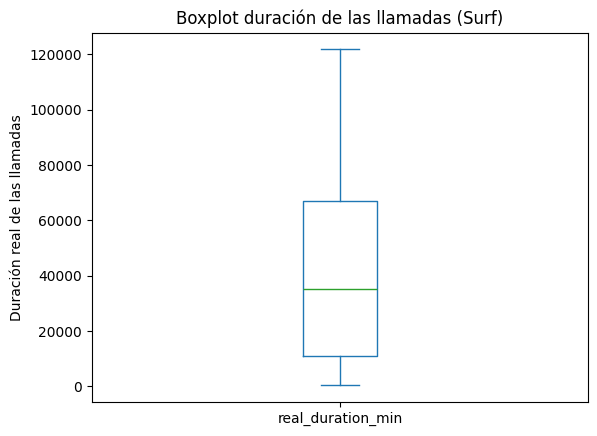

In [2196]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas # SURF

min_data_surf.plot(kind='box', ylabel='Duración real de las llamadas', title='Boxplot duración de las llamadas (Surf)')

plt.show()


<Axes: title={'center': 'Boxplot duración de las llamadas (Ultimate)'}, ylabel='Duración real de las llamadas'>

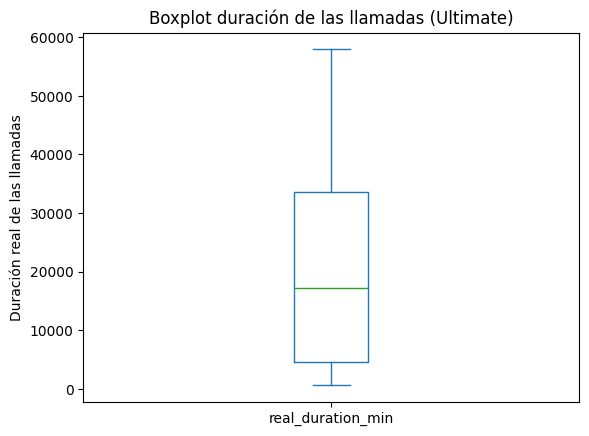

In [2197]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas # ULTIMATE

min_data_ultimate.plot(kind='box', title='Boxplot duración de las llamadas (Ultimate)', ylabel='Duración real de las llamadas')


### Conclusiones de las llamadas

El mes más fuerte en llamadas para surf es diciembre, y para ultimate es febrero. En general, el comportamiento de surf va de menos a más a lo largo del año, mientras que en ultimate varía más. Podemos notar también un poco más de estabilidad a fin de año pero en surf es mucho más claro.

Con la información lanzada de la sección de describe, no me atrevería a decir a que las distribuciones tienen valores atípicos, realmente está muy cerca la desviación estándar de la media en ambos casos, lo que nos indica que los valores suelen seguir cierta tendencia. Esto lo podemos comprobar también gracias al diagrama de caja.

Cabe añadir que, también tiene influencia el hecho de que hay muchos más usuarios surf que ultimate (código abajo), y con eso los datos van a inflarse, dando la apariencia de que los usuarios surf usan más las llamadas. No obstante, gracias al describe, podemos observar que ambas distribuciones tienen un comportamiento similar, solo que cada quien en su propia escala.

Para responder puntualmente a la pregunta si el comportamiento del usuario varía en función del plan, no; las distribuciones son similares, exceptuando el tema de los meses del año.

In [2198]:
# Conteo de usuarios por plan

df_user_combined[df_user_combined['plan'] == "surf"].count() #1180 usuarios en el dataframe

user_id              1180
month                1180
num_calls            1180
real_duration_min    1180
msgs_count           1180
mb_used              1180
plan                 1180
income               1180
dtype: int64

In [2199]:
df_user_combined[df_user_combined['plan'] == "ultimate"].count() #579 usuarios en el dataframe

user_id              579
month                579
num_calls            579
real_duration_min    579
msgs_count           579
mb_used              579
plan                 579
income               579
dtype: int64

### Mensajes

In [2200]:
df_user_combined_surf.head()

,user_id,month,num_calls,real_duration_min,msgs_count,mb_used,plan,income
1,1001,8,27,182,30,7168,surf,20.00
2,1001,9,49,315,44,14336,surf,20.00
3,1001,10,65,393,53,22528,surf,90.09
4,1001,11,64,426,36,19456,surf,60.00
5,1001,12,56,412,44,19456,surf,60.00


In [2201]:
# Compara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan # SURF

msgs_data_surf = df_user_combined_surf.groupby(by=['plan','month']).agg({'msgs_count' : 'sum'})

msgs_data_surf


msgs_count
plan month            
surf 1              21
     2             108
     3             351
     4             864
     5            1778
     6            2292
     7            3096
     8            4439
     9            5672
     10           7507
     11           8739
     12          11731

In [2202]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan # ULTIMATE

msgs_data_ultimate = df_user_combined_ultimate.groupby(by=['plan','month']).agg({'msgs_count' : 'sum'})

msgs_data_ultimate

msgs_count
plan     month            
ultimate 1              62
         2             139
         3             243
         4             463
         5             931
         6            1374
         7            1937
         8            2732
         9            3259
         10           4179
         11           4861
         12           6718

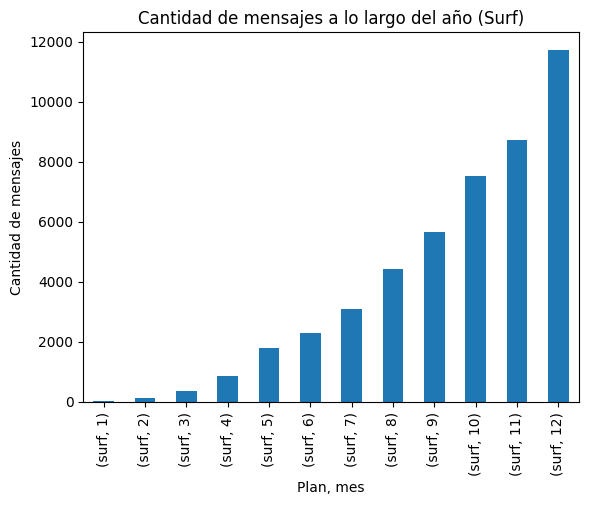

In [2203]:
# Gráfico para el número de llamadas por mes # SURF

msgs_data_surf.plot(kind='bar', legend=False, xlabel='Plan, mes', ylabel='Cantidad de mensajes', title='Cantidad de mensajes a lo largo del año (Surf)')

plt.show()

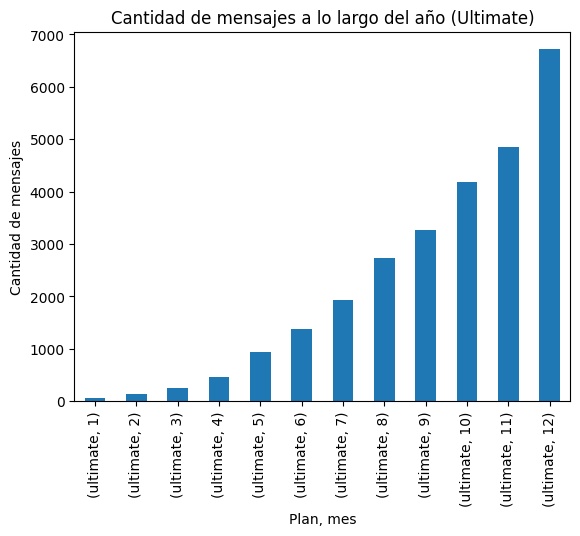

In [2204]:
# Gráfico para el número de llamadas por mes # ULTIMATE

msgs_data_ultimate.plot(kind='bar', legend=False, xlabel='Plan, mes', ylabel='Cantidad de mensajes',title='Cantidad de mensajes a lo largo del año (Ultimate)')

plt.show()


In [2205]:
msgs_data_surf.describe()

,msgs_count
count,12.000000
mean,3883.166667
std,3815.656761
min,21.000000
25%,735.750000
50%,2694.000000
75%,6130.750000
max,11731.000000


In [2206]:
msgs_data_ultimate.describe()

,msgs_count
count,12.000000
mean,2241.500000
std,2149.442063
min,62.000000
25%,408.000000
50%,1655.500000
75%,3489.000000
max,6718.000000


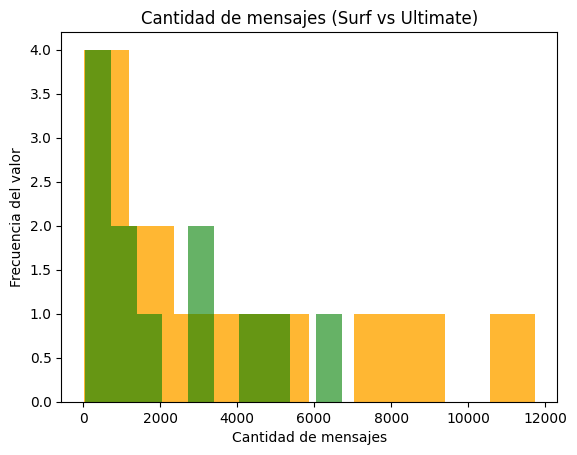

In [2207]:
# Distribución de los mensajes en ambos planes

plt.hist(msgs_data_surf, alpha=0.8, color='orange')
plt.hist(msgs_data_ultimate, alpha=0.6, color='green')
plt.xlabel('Cantidad de mensajes')
plt.ylabel('Frecuencia del valor')
plt.title('Cantidad de mensajes (Surf vs Ultimate)')

plt.show()


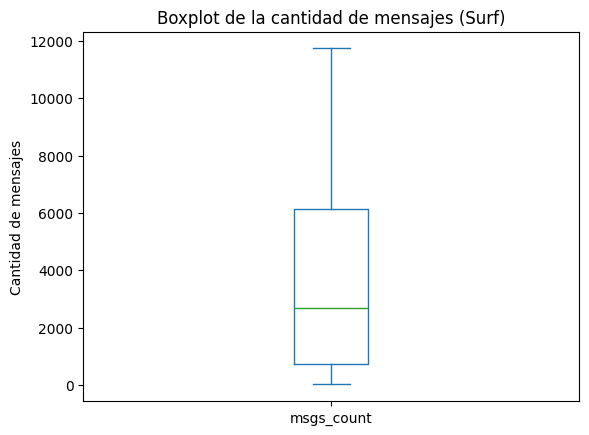

In [2208]:
# Diagramas de caja para cada distribución # SURF

msgs_data_surf.plot(kind='box', title='Boxplot de la cantidad de mensajes (Surf)', ylabel='Cantidad de mensajes')

plt.show()

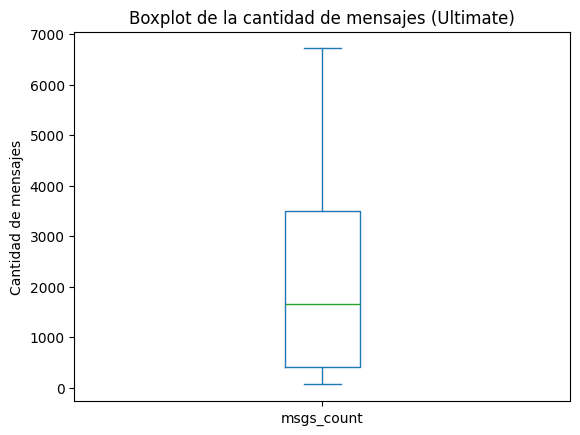

In [2209]:
# Diagramas de caja para cada distribución # ULTIMATE

msgs_data_ultimate.plot(kind='box',title='Boxplot de la cantidad de mensajes (Ultimate)', ylabel='Cantidad de mensajes')

plt.show()

### Conclusiones

El comportamiento de estos datos se me hace similar al anterior de los minutos. Las distribuciones son similares y solamente son diferentes cantidades por la cantidad de usuarios que tiene cada plan. El valor de la desviación estándar está muy cercano al valor de la media, en ambos casos. Está muy cercano a ser nada más una proporcion 2:1 entre ambas distribuciones.

Además de esto, podemos observar que conforme pasaba el año, la cantidad de mensaje iba aumentando. Me hace sospechar que los datos que nos compartió la compañía eran de cuando apenas comenzaron a ofrecer los planes. Esto porque conforme avanza el año, el número de usuarios también fue aumentando poco a poco. Es sólo una suposición, pero en ambos casos lo he podido observar de cierta forma.

Fuera de ello, no diría que el comportamiento de los usuarios varía según el plan.

### Internet

In [2210]:
df_user_combined_surf.head()

,user_id,month,num_calls,real_duration_min,msgs_count,mb_used,plan,income
1,1001,8,27,182,30,7168,surf,20.00
2,1001,9,49,315,44,14336,surf,20.00
3,1001,10,65,393,53,22528,surf,90.09
4,1001,11,64,426,36,19456,surf,60.00
5,1001,12,56,412,44,19456,surf,60.00


In [2211]:
# Compara la cantidad de tráfico de Internet promedio consumido al mes por usuarios por plan # SURF

internet_data_surf = df_user_combined_surf.groupby(by=['plan','month']).agg({'mb_used' : 'mean'})

In [2212]:
# Compara la cantidad de tráfico de Internet promedio consumido al mes por usuarios por plan # ULTIMATE

internet_data_ultimate = df_user_combined_ultimate.groupby(by=['plan','month']).agg({'mb_used' : 'mean'})

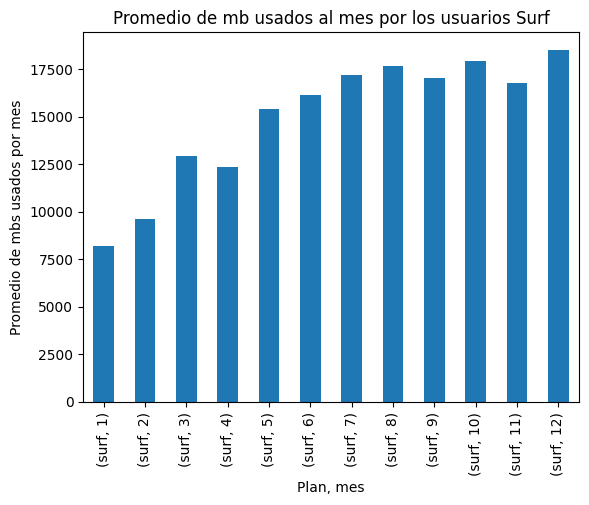

In [2213]:
# Gráfico para internet del plan surf

internet_data_surf.plot(kind='bar', xlabel='Plan, mes', legend=False, ylabel='Promedio de mbs usados por mes', title='Promedio de mb usados al mes por los usuarios Surf')

plt.show()

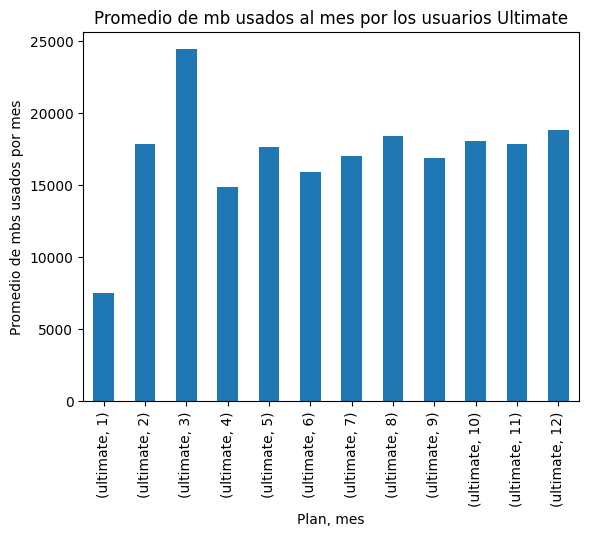

In [2214]:
# Gráfico para internet del plan ultimate

internet_data_ultimate.plot(kind='bar', xlabel='Plan, mes', legend=False, ylabel='Promedio de mbs usados por mes', title='Promedio de mb usados al mes por los usuarios Ultimate')

plt.show()

In [2215]:
internet_data_surf.describe()

,mb_used
count,12.000000
mean,14985.922745
std,3414.219110
min,8192.000000
25%,12789.942857
50%,16466.604456
75%,17325.841186
max,18523.577236


In [2216]:
internet_data_ultimate.describe()

,mb_used
count,12.000000
mean,17095.295656
std,3804.415265
min,7509.333333
25%,16616.417206
50%,17734.704762
75%,18152.727273
max,24429.714286


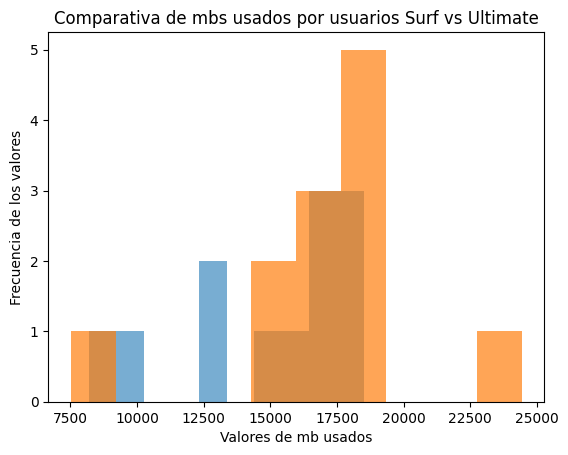

In [2217]:
plt.hist(internet_data_surf, alpha=0.6)
plt.hist(internet_data_ultimate, alpha=0.7)
plt.title('Comparativa de mbs usados por usuarios Surf vs Ultimate')
plt.xlabel('Valores de mb usados')
plt.ylabel('Frecuencia de los valores')

plt.show()

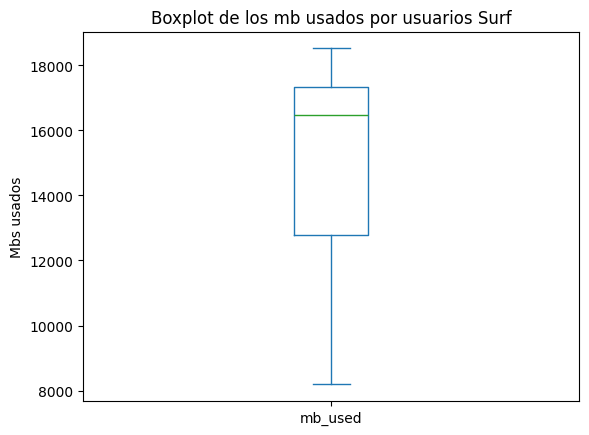

In [2218]:
internet_data_surf.plot(kind='box', title='Boxplot de los mb usados por usuarios Surf', ylabel='Mbs usados')
plt.show()

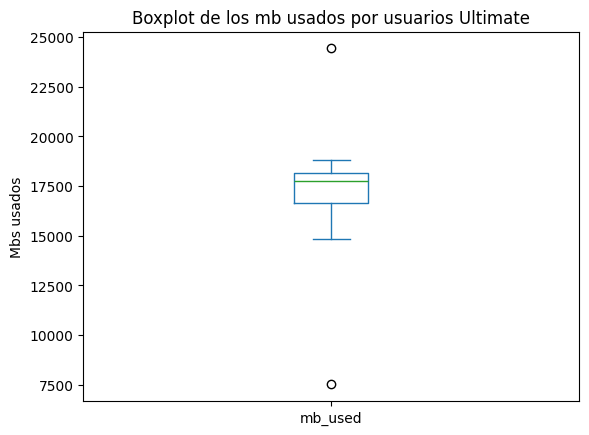

In [2243]:
internet_data_ultimate.plot(kind='box', title='Boxplot de los mb usados por usuarios Ultimate', ylabel='Mbs usados')
plt.show()

En este caso del internet hay unas cuantas curiosidades. Comenzamos con que existen meses donde el consumo es más fuerte para cada uno de los planes; en el caso del plan surf, podemos ver que el mes de mayor uso de internet es diciembre, mientras que para el plan ultimate, es el mes de marzo.

Luego podemos ver que, para la distribución del plan surf, existe una distribución común, con valores dentro de lo esperado, mientras que el plan ultimate presenta valores atípicos, fuera de los rangos y lo podemos visualizar en el boxplot. Esto surge a raíz de lo comentado anteriormente, que el mes de marzo es el de mayor consumo de internet, y se desvía bastante de lo que tenemos en los otros meses.

Considero que aquí sí hay comportamientos diferentes según el plan que tiene cada usuario, hablando del plan ultimate teniendo valores fuertes en marzo y en surf siendo diciembre.

## Ingreso

[Del mismo modo que has estudiado el comportamiento de los usuarios, describe estadísticamente los ingresos de los planes.]

In [2220]:
df_user_combined_surf.head()

,user_id,month,num_calls,real_duration_min,msgs_count,mb_used,plan,income
1,1001,8,27,182,30,7168,surf,20.00
2,1001,9,49,315,44,14336,surf,20.00
3,1001,10,65,393,53,22528,surf,90.09
4,1001,11,64,426,36,19456,surf,60.00
5,1001,12,56,412,44,19456,surf,60.00


In [2221]:
surf_income = df_user_combined_surf.groupby(by=['plan','month']).agg({'income':'sum'})

surf_income.head()

income
plan month         
surf 1        20.00
     2       119.57
     3       616.65
     4      1420.70
     5      2695.43

In [2222]:
ultimate_income = df_user_combined_ultimate.groupby(by=['plan','month']).agg({'income':'sum'})

ultimate_income.head()

income
plan     month        
ultimate 1       210.0
         2       350.0
         3       546.0
         4      1169.0
         5      1491.0

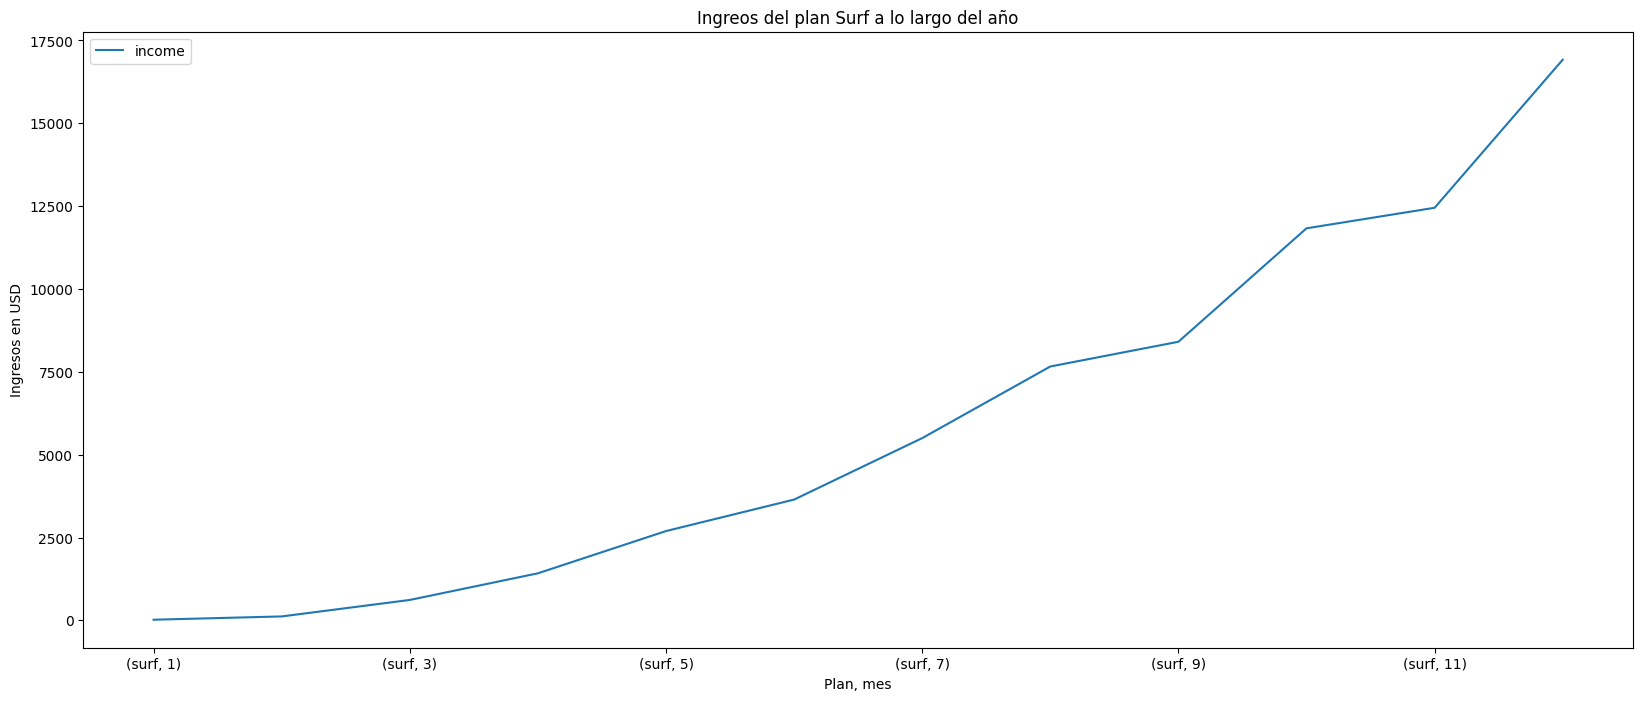

In [2244]:
surf_income.plot(kind='line',figsize=[20,8], xlabel='Plan, mes', ylabel='Ingresos en USD', title='Ingreos del plan Surf a lo largo del año')

plt.show()

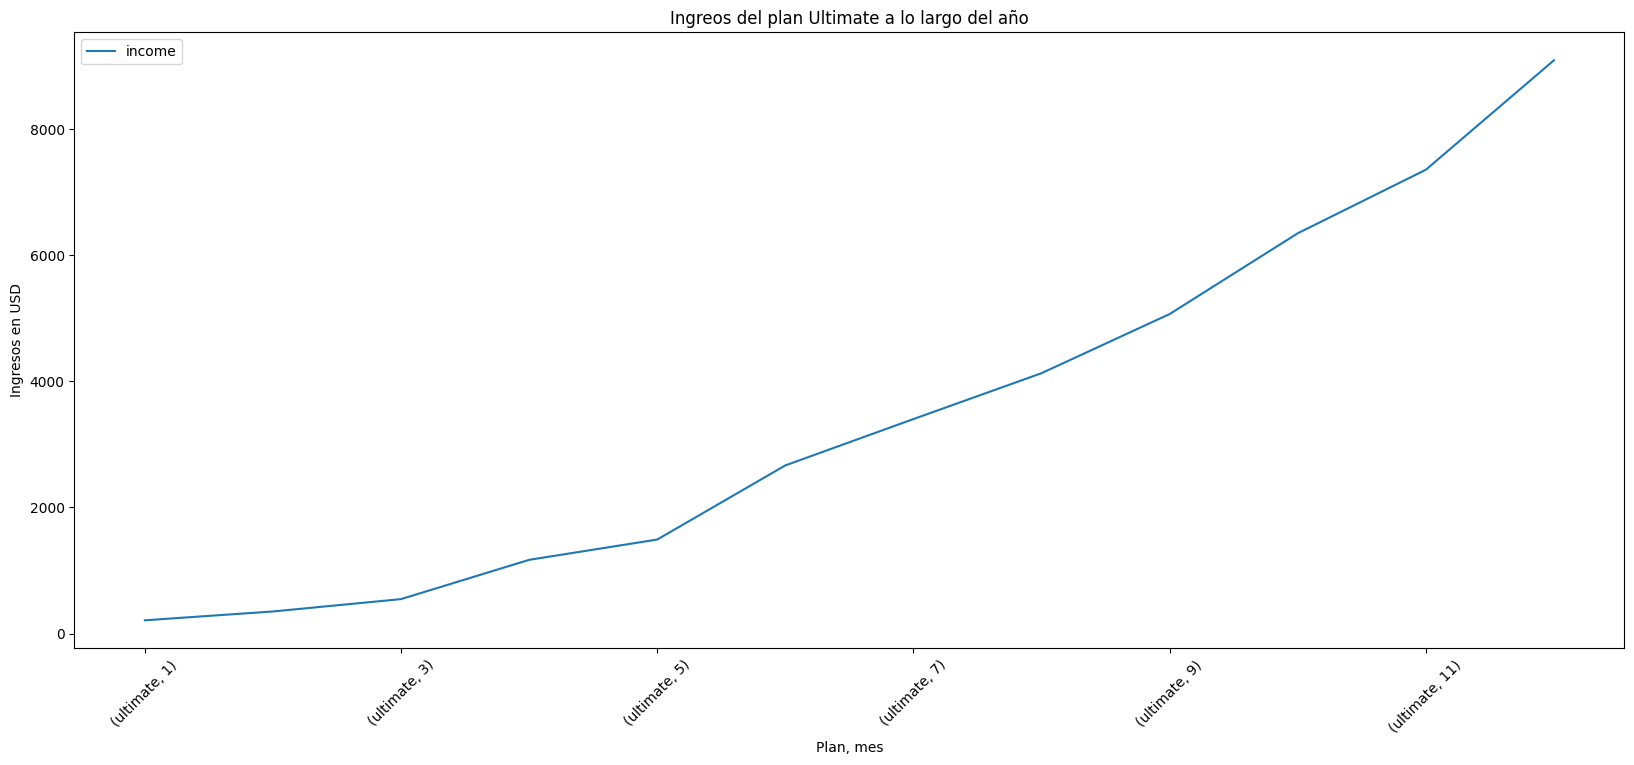

In [2245]:
ultimate_income.plot(kind='line',rot=45,figsize=[20,8], xlabel='Plan, mes', ylabel='Ingresos en USD', title='Ingreos del plan Ultimate a lo largo del año')
plt.show()

In [2225]:
surf_income.describe()

,income
count,12.000000
mean,5940.890833
std,5562.697076
min,20.000000
25%,1219.687500
50%,4573.220000
75%,9263.872500
max,16919.280000


In [2226]:
ultimate_income.describe()

,income
count,12.000000
mean,3486.000000
std,2966.079782
min,210.000000
25%,1013.250000
50%,3034.500000
75%,5388.250000
max,9093.000000


In [2227]:
# Cuántos usuarios se pasaron de utilizar lo limitado en su paquete? #Surf
# Se extraen los valores de cuántos usuarios pagaron más de su cuota de 20 dls y los que no, se suma el total de usuarios y todo se adjunta en un nuevo dataframe, de ahí sacaremos cuántas personas se pasaron de su límite.

df_over_surf = df_user_combined_surf[df_user_combined_surf['income'] > 20].groupby(by=['month','plan']).agg({'user_id':'count'})

In [2228]:
df_inlimit_surf = df_user_combined_surf[df_user_combined_surf['income'] == 20].groupby(by=['month','plan']).agg({'user_id':'count'})

In [2229]:
df_totalusers_surf = df_user_combined_surf.groupby(by=['plan','month']).agg({'user_id':'count'})

In [2230]:
df_overincome_surf = df_over_surf.merge(df_inlimit_surf, on='month', suffixes=['_over','_inlimit']).merge(df_totalusers_surf, on='month')

df_overincome_surf

,user_id_over,user_id_inlimit,user_id
month,,,
2,2,3,5
3,8,8,16
4,17,18,35
5,34,19,53
6,48,22,70
7,70,19,89
8,84,35,119
9,113,34,147
10,134,47,181


In [2231]:
df_overincome_surf['percentage'] = (df_overincome_surf['user_id_over']*100) / df_overincome_surf['user_id_inlimit']

df_overincome_surf

,user_id_over,user_id_inlimit,user_id,percentage
month,,,,
2,2,3,5,66.666667
3,8,8,16,100.000000
4,17,18,35,94.444444
5,34,19,53,178.947368
6,48,22,70,218.181818
7,70,19,89,368.421053
8,84,35,119,240.000000
9,113,34,147,332.352941
10,134,47,181,285.106383


In [2232]:
# Cuántos usuarios se pasaron de utilizar lo limitado en su paquete? #Ultimate
# Mismo procedimiento que el plan anterior, pero en una sola celda de código

df_over_ultimate = df_user_combined_ultimate[df_user_combined_ultimate['income'] > 70].groupby(by=['month','plan']).agg({'user_id':'count'})
df_inlimit_ultimate = df_user_combined_ultimate[df_user_combined_ultimate['income'] == 70].groupby(by=['month','plan']).agg({'user_id':'count'})
df_totalusers_ultimate = df_user_combined_ultimate.groupby(by=['plan','month']).agg({'user_id':'count'})
df_overincome_ultimate = df_over_ultimate.merge(df_inlimit_ultimate, on='month', suffixes=['_over','_inlimit']).merge(df_totalusers_ultimate, on='month')
df_overincome_ultimate['percentage'] = (df_overincome_ultimate['user_id_over']*100) / df_overincome_ultimate['user_id_inlimit']

df_overincome_ultimate



,user_id_over,user_id_inlimit,user_id,percentage
month,,,,
3,3,4,7,75.000000
4,1,15,16,6.666667
5,1,20,21,5.000000
6,2,35,37,5.714286
7,2,45,47,4.444444
8,3,54,57,5.555556
9,3,68,71,4.411765
10,4,84,88,4.761905
11,5,97,102,5.154639


### Conclusiones

A pesar de ser más costoso el plan ultimate, por la cantidad de usuarios podemos ver que existe mayor ingreso por el plan surf. Esto es de esperar ya que es el plan "económico" y que satisface todas las necesidades, siempre y cuando te mantengas al margen de lo que te entregan con el paquete y no te sobrepases mucho en los límites de mensajes, llamadas e internet.

Observando ambos gráficos de ingresos, presentan un aumento casi exponencial conforme avanza el año, observamos una curvatura que tiende a subir según avanzan los meses. 
Para el caso del plan surf, vemos que existe un pequeño decremento de los ingresos, que sería en el mes de septiembre y noviembre, que es ligero, pero se alcanza a visualizar claramente en la gráfica.
Para el plan ultimate, vemos que existe un pequeño decremento pero en el mes de mayo.

Claro que a lo largo de todo el año hay variaciones, pero esas son las más importantes a destacar.

Así mismo, podemos observar que es usual que un usuario del plan surf, consuma más de lo que el paquete le entrega, y esto genera tarifas más altas a los $20. Por otro lado, los usuarios ultimate rara vez llegan al límite de lo ofertado, probablemente porque es complicado consumir absolutamente todo lo que ofrece el plan en un mes.

## Prueba las hipótesis estadísticas

- Hipótesis nula: Los ingresos promedio de los usuarios de los planes Ultimate y Surf son los mismos.
- Hipótesis alternativa: Los ingresos promedio de los usuarios de los planes Ultimate y Surf son diferentes.

In [2233]:
df_surf_avgincome_month = df_user_combined_surf.groupby(by=['plan','month']).agg({'income':'mean'}) # Calculamos el ingreso promedio al mes del plan surf

df_ultimate_avgincome_month = df_user_combined_ultimate.groupby(by=['plan','month']).agg({'income':'mean'}) # Calculamos el ingreso promedio al mes del plan ultimate

In [2234]:
df_surf_avgincome_month.var() # Verificamos la varianza del plan surf agrupado al mes

income    258.43987
dtype: float64

In [2235]:
df_ultimate_avgincome_month.var() # Verificamos la varianza del plan ultimate agrupado al mes

income    4.22842
dtype: float64

Consideraremos las varianzas desiguales, ya que al dividir la varianza mayor entre la varianza menor, obtenemos un valor mayor a 2 (64.5).

In [2236]:
# Prueba las hipótesis

alpha = 0.05

results = st.ttest_ind(df_ultimate_avgincome_month, df_surf_avgincome_month, equal_var=False) # Nos devuelve 0.0005

if (results.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

Rechazamos la hipótesis nula


Con esta prueba concluimos que podemos rechazar la hipótesis nula, donde los ingresos de ambos planes son iguales. Aquí observamos que tienen diferencias.

### Usuarios NY y NJ

In [2237]:
# Crear un dataframe con la información de las ciudades de cada usuario

df_citiesperuser = df_users[['user_id', 'city']] # Extraer la ciudad de cada usuario
df_users_and_cities = df_user_combined.merge(df_citiesperuser, on='user_id') # Combinamos los dataframes de todos los usuarios (sin importar su plan) y el de la información de las ciudades.

df_NYNJ = df_users_and_cities[df_users_and_cities['city'] == "New York-Newark-Jersey City, NY-NJ-PA MSA"] # Enmascaramos para tener un dataframe de los usuarios en NY y NJ

df_not_NY_NJ = df_users_and_cities[df_users_and_cities['city'] != "New York-Newark-Jersey City, NY-NJ-PA MSA"] # Enmascaramos para tener un dataframe de los usuarios fuera de NY y NJ

- Hipótesis nula: Los ingresos promedio de los usuarios del área de NY-NJ son iguales al resto de las regiones.
- Hipótesis alternativa: Los ingresos promedio de esa área varían al compararlos con el del resto de las regiones.

In [2238]:
df_avgincome_NYNJ = df_NYNJ.groupby(by='month').agg({'income':'mean'})

In [2239]:
df_avgincome_NYNJ.var()

income    182.75292
dtype: float64

In [2240]:
df_avgincome_not_NYNJ = df_not_NY_NJ.groupby(by='month').agg({'income':'mean'})

In [2241]:
df_avgincome_not_NYNJ.var()

income    49.855531
dtype: float64

Consideraremos las varianzas desiguales, se ejecuta una división donde hacemos la varianza mayor entre la varianza menor, y si el valor es mayor a 2 (obtenemos 3.71), las varianzas se consideran desiguales; con ese fundamento aplicaremos la prueba t

In [2242]:
# Prueba las hipótesis
# Conservaremos alpha igual que el caso anterior

results2 = st.ttest_ind(df_avgincome_NYNJ, df_avgincome_not_NYNJ, equal_var=False) # Nos devuelve 0.036 el pvalue

if (results2.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

Rechazamos la hipótesis nula


Con esto podemos decir que no existe prueba significativa que permita sustentar la hipótesis nula. Descartamos que los ingresos de NY y de NJ son iguales al resto de las regiones.

## Conclusión general

[En esta sección final, enumera tus conclusiones importantes. Asegúrate de que estas abarquen todas las decisiones (suposiciones) importantes que adoptaste y que determinaron la forma elegida para procesar y analizar los datos.]

La primera impresión importante y que valdría la pena considerar es que, este dataframe parece que es nuevo en el sentido de que, a lo largo del año, más usuarios se fueron suscribiendo y por ello encontramos variaciones en los meses de las cantidades. Valdría la pena encontrar otro dataframe donde desde inicios del año haya una cantidad fuerte de usuarios y que no exista tanta diferencia al cerrar el año. Desconozco si este es el primer dataset que recopilaron en la empresa de Megaline, pero eso fue lo que encontré a lo largo del análisis.

Así mismo, debemos destacar la cantidad de usuarios del plan surf vs el plan ultimate. A lo largo de todo el estudio, encontramos que les superaba en mucho la cantidad de usuarios con plan surf vs el plan ultimate. Esto es fácil de ausmir por el costo que tienen ambos paquetes, aunque tengan diferencias en la cantidad de beneficios que otorgan.

No obstante, está muy bien saber también que un usuario del plan surf está dispuesto muchas veces a pagar de más con tal de utilizar unos megas de internet más, o unas llamadas extras. Mientras que los usuarios de ultimante no suelen terminarse sus paquetes con los beneficios contenidos al mes.

Podemos observar también que los usuarios del plan ultimate tienen más actividad en general durante el inicio del año, y los usuarios del plan surf tienen mayor actividad a final de año, con especial énfasis en el mes de diciembre.

Aún con estas diferencias en cantidades de usuarios, puedo observar que las distribuciones de los planes surf y ultimate, dan la impresión de ser similares en general, solamente que el plan surf al tener tantos usuarios, da la impresión de que siempre está gastando y generando más. Valdría la pena ver si se puede equiparar la cantidad de usuarios ultimate para futuros análisis y ver verdaderamente cómo se están comportando los usuarios.